In [9]:
# t,r (try this first)
# r distribution: more samples around r=1

import numpy as np
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import os

np.random.seed(1)
torch.manual_seed(1)

# Define Transformer

class T(nn.Module):
    def __init__(self,w=256):
        super(T, self).__init__()
        self.l1 = nn.Linear(input_d,w)
        #self.l1 = nn.Linear(input_d,w)
        self.l2 = nn.Linear(w,w)
        self.l3 = nn.Linear(w,input_d)
    
    def forward(self, x, eps=1.0):
        bs = x.shape[0]
        #f = nn.ReLU()
        f = nn.Tanh()
        #self.x1 = f(self.l1(x[:,1:]))
        self.x1 = f(self.l1(x))
        self.x2 = f(self.l2(self.x1))
        self.x3 = self.l3(self.x2)
        #self.x3fill = torch.cat([torch.zeros(bs,1, requires_grad=True), self.x3], dim=1)
        return x + eps*self.x3
        #return torch.transpose(torch.stack([x[:,0],x[:,1]*x[:,0],x[:,2]*x[:,0],x[:,3]*x[:,0]]),0,1)
    
    
    def transform_g(self, x):
        jac_t = torch.autograd.functional.jacobian(self.forward,x,create_graph=True)
        jac_ts = []
        for i in range(jac_t.shape[0]):
            jac_ts.append(jac_t[i,:,i,:])

        jac_ts = torch.stack(jac_ts)
        jac_inv_ts = torch.inverse(jac_ts)
        return torch.matmul(torch.matmul(jac_inv_ts.permute(0,2,1), g(x)),jac_inv_ts)

In [10]:
def Minkowski_loss(g,t,inputs):
    gp = t.transform_g(inputs)
    bs = gp.shape[0]
    minkowski_metric = torch.unsqueeze(torch.unsqueeze(torch.ones(bs,),dim=1),dim=2) * torch.unsqueeze(torch.diag(torch.tensor([1.,-1.,-1.,-1.], dtype=torch.float, requires_grad=True)), dim=0)
    return torch.mean((gp-minkowski_metric)**2)


def Jp_(g,t,inputs):
    input_d = input_.shape[1]
    jac = torch.autograd.functional.jacobian(g,inputs,create_graph=True)
    jac_f = []
    for i in range(jac.shape[0]):
        jac_f.append(jac[i,:,:,i,:])

    # SHAPE
    jac_f = torch.stack(jac_f)
    #print(jac_f.shape)

    # get jacobian of t
    jac_t = torch.autograd.functional.jacobian(t,inputs,create_graph=True)

    jac_ts = []
    for i in range(jac_t.shape[0]):
        jac_ts.append(jac_t[i,:,i,:])

    # SHAPE
    jac_ts = torch.stack(jac_ts)
    jac_inv_ts_tp = torch.inverse(jac_ts).permute(0,2,1)

    # get Hessian of t
    gradsss = []
    for i in range(input_d):
        gradss = []
        for j in range(input_d):
            grads = torch.autograd.grad(jac_inv_ts_tp[:,i,j], inputs, torch.ones_like(jac_inv_ts_tp[:,i,j]), create_graph=True)[0]
            gradss.append(grads)
        gradss = torch.stack(gradss)
        gradsss.append(gradss)
    # SHAPE
    hess_t = torch.stack(gradsss).permute(2,0,1,3)
    #print(hess_t.shape)

    # calculate J'
    Jp1 = jac_inv_ts_tp.unsqueeze(dim=1).unsqueeze(dim=2).unsqueeze(dim=5).unsqueeze(dim=6)*hess_t.permute(0,1,3,2).unsqueeze(dim=2).unsqueeze(dim=3).unsqueeze(dim=6)*g(inputs).unsqueeze(dim=1).unsqueeze(dim=2).unsqueeze(dim=3).unsqueeze(dim=4)*jac_inv_ts_tp.unsqueeze(dim=1).unsqueeze(dim=3).unsqueeze(dim=4).unsqueeze(dim=5)
    Jp2 = jac_inv_ts_tp.unsqueeze(dim=1).unsqueeze(dim=2).unsqueeze(dim=5).unsqueeze(dim=6)*jac_inv_ts_tp.unsqueeze(dim=2).unsqueeze(dim=3).unsqueeze(dim=4).unsqueeze(dim=6)*jac_f.permute(0,2,3,1).unsqueeze(dim=1).unsqueeze(dim=2).unsqueeze(dim=3)*jac_inv_ts_tp.unsqueeze(dim=1).unsqueeze(dim=3).unsqueeze(dim=4).unsqueeze(dim=5)
    Jp3 = jac_inv_ts_tp.unsqueeze(dim=1).unsqueeze(dim=2).unsqueeze(dim=5).unsqueeze(dim=6)*jac_inv_ts_tp.unsqueeze(dim=2).unsqueeze(dim=3).unsqueeze(dim=4).unsqueeze(dim=6)*g(inputs).unsqueeze(dim=1).unsqueeze(dim=2).unsqueeze(dim=3).unsqueeze(dim=4)*hess_t.permute(0,2,1,3).unsqueeze(dim=1).unsqueeze(dim=3).unsqueeze(dim=5)
    Jp = Jp1 + Jp2 + Jp3
    Jp = torch.sum(torch.sum(torch.sum(Jp,dim=6),dim=5),dim=4)
    #print(Jp.shape)
    return Jp


def lie_loss(g,t,inputs):
    
    bs = inputs.shape[0]
    # for SO(3)
    g_J1 = torch.tensor([[0,1,0],[-1,0,0],[0,0,0]], dtype=torch.float, requires_grad=True)
    g_J2 = torch.tensor([[0,0,1],[0,0,0],[-1,0,0]], dtype=torch.float, requires_grad=True)
    g_J3 = torch.tensor([[0,0,0],[0,0,1],[0,-1,0]], dtype=torch.float, requires_grad=True)
    g_Js = [g_J1,g_J2,g_J3]
    
    Jp = Jp_(g,t,inputs)
    gp = t.transform_g(inputs)
    inputsp = torch.unsqueeze(t(inputs), dim=2)
    #print(Jp.shape)
    
    pde = 0
    for g_J in g_Js:
        g_J = torch.unsqueeze(torch.unsqueeze(torch.ones(bs,),dim=1),dim=1) * torch.unsqueeze(g_J, dim=0)
        #print(Jp.permute(0,1,2).shape)
        #print(g_J.shape)
        #print(gp.shape)
        pde = pde + torch.mean((torch.matmul(torch.matmul(Jp.reshape(bs,4*4,4),g_J),inputsp).reshape(bs,4,4))**2)
        
    g_mse = torch.mean(gp**2)
    return pde/g_mse

In [11]:
torch.randperm(10)

tensor([5, 6, 1, 2, 0, 8, 9, 3, 7, 4])

In [12]:
def euclidean_loss(g,t,inputs):
    gp = t.transform_g(inputs)
    bs = gp.shape[0]
    minkowski_metric = torch.unsqueeze(torch.unsqueeze(torch.ones(bs,),dim=1),dim=2) * torch.unsqueeze(torch.diag(torch.tensor([-1.,-1.,-1.], dtype=torch.float, requires_grad=True)), dim=0)
    return torch.mean((gp[:,1:,1:]-minkowski_metric)**2)

def time_inv_loss(g,t,inputs):
    gp = t.transform_g(inputs)
    bs = gp.shape[0]
    inputs_new = inputs.clone()
    inputs_new[:,0] = inputs_new[:,0][torch.randperm(bs)]
    gp_new = t.transform_g(inputs_new)
    return torch.mean((gp-gp_new)**2)
    

In [16]:
from celluloid import Camera
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,5))
camera = Camera(fig)


# Training a transformer to minimize PDE losses

def g(x_):
    bs = x_.shape[0]
    t = x_[:,0]
    #a = t
    a = torch.ones_like(t)
    x = x_[:,1]
    y = x_[:,2]
    z = x_[:,3]
    r = torch.sqrt(x**2+y**2+z**2)
    stack1 = torch.stack([torch.ones(bs,)-1/r, torch.zeros(bs,), torch.zeros(bs,), torch.zeros(bs,)])
    stack2 = torch.stack([torch.zeros(bs,), -(1+x**2/((r-1)*r**2)), -x*y/((r-1)*r**2), -x*z/((r-1)*r**2)])
    stack3 = torch.stack([torch.zeros(bs,), -x*y/((r-1)*r**2), -(1+y**2/((r-1)*r**2)), -y*z/((r-1)*r**2)])
    stack4 = torch.stack([torch.zeros(bs,), -x*z/((r-1)*r**2), -y*z/((r-1)*r**2), -(1+z**2/((r-1)*r**2))])
    gs = torch.stack([stack1, stack2, stack3, stack4]).permute(2,0,1)
    return gs
        
        


input_d = 1000


np.random.seed(0)
torch.manual_seed(0)

t = T(w=400)
epochs = 3000
switch_epoch = 200

n_train = 1000
batch_size = 16

lr = 5e-3
optimizer = optim.Adam(t.parameters(), lr=lr)

log = 10

losses = []

for epoch in range(epochs):
    
    if (epoch+1) % 1000 == 0:
        lr = lr * 0.2
        optimizer = optim.Adam(t.parameters(), lr=lr)

    t.train()
    optimizer.zero_grad()
    
    #W = torch.rand(1000,4, requires_grad=True)
    W = torch.normal(0,1,size=(1000,4),requires_grad=True)
    #input_ = W
    input_ = torch.empty(1000,4, requires_grad=False)
    input_[:,0] = (torch.rand(1000, requires_grad=True)-0.5)*3.0 + 1.5
    #input_[:,1:] = torch.abs(torch.rand(1000, requires_grad=True))
    #rs = 1.5 + torch.abs(torch.normal(0,1,size=(1000,), requires_grad=True)*2)
    rs = 1.05 + 1.95 * torch.rand(1000, requires_grad=True)
    #rs2 = 0.2 + 0.6 * torch.rand(500, requires_grad=True)
    #rs = torch.cat([rs1, rs2])
    input_[:,1:] = W[:,1:]/torch.norm(W[:,1:], dim=1, keepdim=True)*torch.unsqueeze(rs, dim=1)

    choices = np.random.choice(n_train, batch_size)
    inputs = input_[choices]

    #loss = lie_loss(g,t,inputs)
    loss1 = euclidean_loss(g,t,inputs)
    loss2 = time_inv_loss(g,t,inputs)
    loss = loss1 + loss2
    losses.append(loss.detach().numpy())
    #loss.backward(retain_graph=True)
    loss.backward(retain_graph=True)
    optimizer.step()

    if epoch == epochs-1:
        batches = int((input_.shape[0]-1)/batch_size)+1
        loss = 0
        for j in range(batches):
            print("{}/{}".format(j,batches))
            if j < batches-1:
                inputs = input_[j*batch_size:(j+1)*batch_size]
            else:
                inputs = input_[j*batch_size:]

            loss_mkw = euclidean_loss(g,t,inputs)
            loss = loss + loss_mkw*inputs.shape[0]
        loss = loss/input_.shape[0]
        print("Average loss: %.4f " % loss)
        losses.append(loss.detach().numpy())

    if epoch%log == 0:
        print('Epoch:  %d | Eud: %.4f | Time-inv: %.4f | loss: %.4f ' %(epoch, loss1, loss2, loss))


RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x4 and 1000x400)

<Figure size 1080x360 with 0 Axes>

In [93]:
xp = t(input_)
tps = xp[:,0].detach().numpy()
rs = torch.norm(input_[:,1:], dim=1).detach().numpy()
rps = torch.norm(xp[:,1:], dim=1).detach().numpy()
tdiff = (input_[:,0] - 0.68*xp[:,0]).detach().numpy()

In [94]:
a_true = -2*np.sqrt(rs) + np.log((np.sqrt(rs)+1)/(np.sqrt(rs)-1))

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


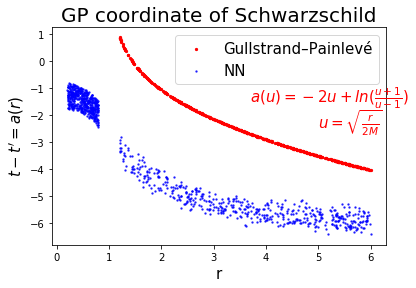

In [96]:
plt.scatter(rs, a_true, s=5,color="red")
plt.scatter(rs, tdiff-6.9, s=2, alpha=0.7, color="blue")
plt.legend(["Gullstrand–Painlevé","NN"],fontsize=15)
plt.xlabel("r", fontsize=15)
plt.text(3.7,-1.5,r"$a(u)=-2u+ln(\frac{u+1}{u-1})$",color="red",fontsize=15)
plt.text(5,-2.5,r"$u=\sqrt{\frac{r}{2M}}$",color="red",fontsize=15)
plt.ylabel(r"$t-t' = a(r)$", fontsize=15)
plt.title("GP coordinate of Schwarzschild",fontsize=20)
plt.savefig('./figures/gp.pdf')

(0, 10)

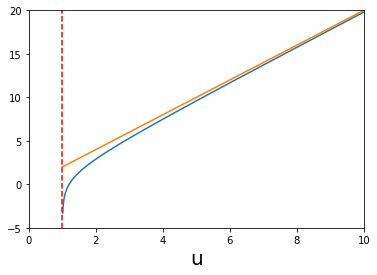

In [69]:
#u = np.sqrt(np.array(rs))
u = np.linspace(1.01,10,num=1000)
f = 2*u + np.log((u-1)/(u+1))
f2 = 2*u
plt.plot(u,f)
plt.plot(u,f2)
plt.plot([1,1],[-20,30], ls="--", color="red")
plt.xlabel("u",fontsize=20)
plt.ylim(-5,20)
plt.xlim(0,10)

In [23]:
np.savetxt("./GP_true.txt", np.transpose(np.array([np.array(rs), np.array(a_true)])))

In [24]:
np.savetxt("./GP_nn.txt", np.transpose(np.array([np.array(rs), np.array(-tdiff-6.9)])))

In [25]:
rs = np.loadtxt("./GP_true.txt")[:,0]
a_true = np.loadtxt("./GP_true.txt")[:,1]
a_pred = np.loadtxt("./GP_nn.txt")[:,1]

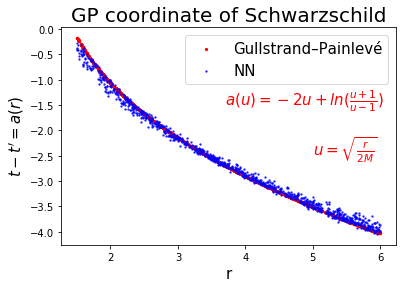

In [26]:
plt.scatter(rs, a_true, s=5,color="red")
plt.scatter(rs, a_pred, s=2, alpha=0.7, color="blue")
plt.legend(["Gullstrand–Painlevé","NN"],fontsize=15)
plt.xlabel("r", fontsize=15)
plt.text(3.7,-1.5,r"$a(u)=-2u+ln(\frac{u+1}{u-1})$",color="red",fontsize=15)
plt.text(5,-2.5,r"$u=\sqrt{\frac{r}{2M}}$",color="red",fontsize=15)
plt.ylabel(r"$t-t' = a(r)$", fontsize=15)
plt.title("GP coordinate of Schwarzschild",fontsize=20)
plt.savefig('./figures/gp.pdf')